In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation_pc1


In [178]:
%load_ext autoreload
%autoreload
from src.modules.data_preprocessing import load_data
from dython.nominal import correlation_ratio
from src.fed_imp.sub_modules.missing_simulate.missing_adder_new import simulate_nan_new
import missingno as msno
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neural_network import MLPClassifier
from src.modules.evaluation.imputation_quality import rmse, ws_cols
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.utils import resample, shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import BayesianRidge

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [160]:
def evaluation_clf(X_train, X_test, y_train, y_test, clf):
    if clf == 'mlp':
        clf = MLPClassifier(
            hidden_layer_sizes=(32), max_iter=1000, alpha=0.0001,
            solver='adam', verbose=0, random_state=21, tol=0.001
        )
    elif clf == 'rf':
        clf = RandomForestClassifier(n_estimators=500, random_state=0)
    elif clf == 'lr':
        clf = LogisticRegression(C=10,random_state=0)
    else:
        raise ValueError('clf must be mlp')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accu = accuracy_score(y_test, y_pred)
    print(accu)

    return clf


In [140]:
data, data_config = load_data('ijcnn_balanced_pca')
for col in data.columns:
    print(correlation_ratio(data[data_config['target']], data[col]))

0.01116517890897829
0.03267700062091216
0.031400763890750215
0.039969187075791016
0.0540549242259297
0.0014362874682960298
0.003178613046171974
0.001813233691676679
0.01009228530599031
0.01116177496512077
0.02020280001556555
0.10931558794720164
0.09072184865463064
0.08322469224633745
0.2247464099306634
0.3388307896542788
0.3546298383672207
0.0028373615640717633
0.4482299191224962
0.024058954996967183
1.0


In [196]:
data_sampled = data.sample(frac=0.1, random_state=42)
print(data_sampled.shape)
data_sampled = data_sampled.values
X_train, X_test, y_train, y_test = train_test_split(
    data_sampled[:, :-1], data_sampled[:, -1], test_size=0.2, stratify=data_sampled[:,-1], random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
#evaluation_clf(X_train, X_test, y_train, y_test, 'mlp')
evaluation_clf(X_train, X_test, y_train, y_test, 'rf')
evaluation_clf(X_train, X_test, y_train, y_test, 'lr')

(3684, 21)
(2947, 20) (737, 20) (2947,) (737,)
0.9063772048846676
0.8670284938941656


d:\E\miniconda\envs\fed_imp\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10, random_state=0)

(2947, 21)


<Axes: >

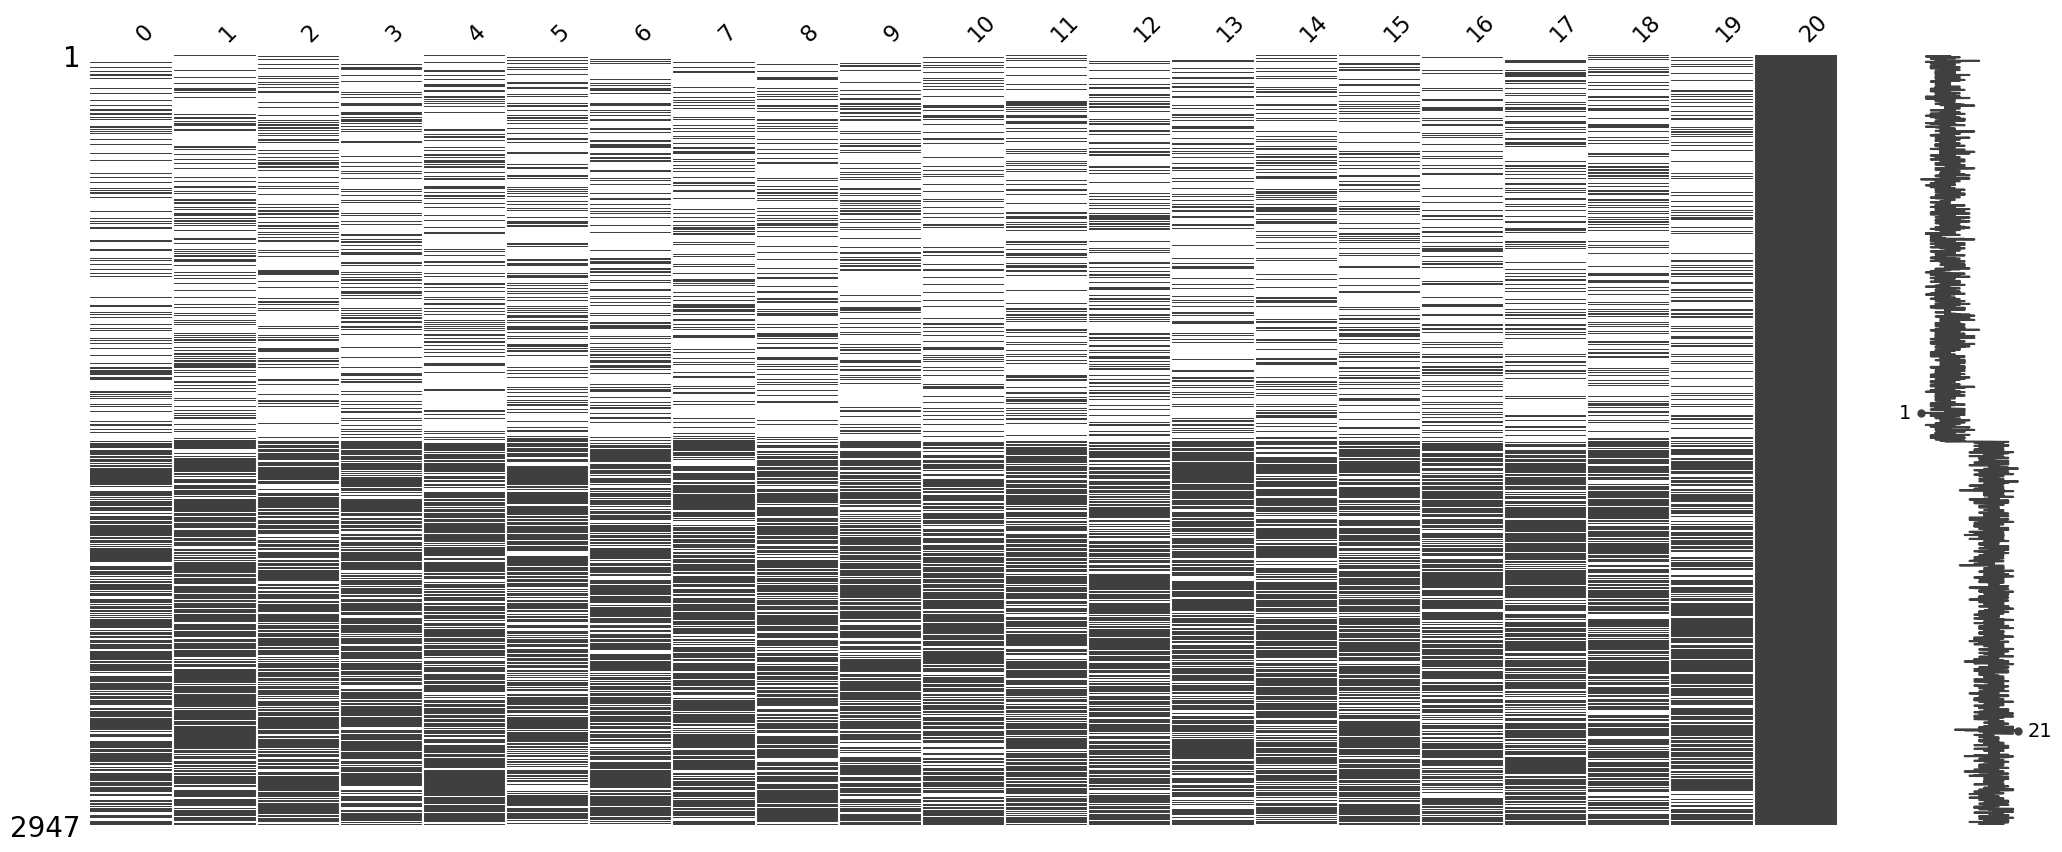

In [198]:
cols = list(range(X_train.shape[1]))
X_train_ms = simulate_nan_new(X_train, y_train, 
                           cols = cols, mechanism='mary_sigmoid_left', missing_ratio=0.5, seed=42)
data_ms = np.concatenate([X_train_ms, y_train.reshape(-1,1)], axis=1)
print(data_ms.shape)
df = pd.DataFrame(data_ms)
mask = np.isnan(X_train_ms)
msno.matrix(df.sort_values(by=df.columns[-1]))

## Mean Imputation

In [200]:
# single imputation without sampling
base_estimator = BayesianRidge()
X_imp = IterativeImputer(
    random_state=42, min_value = np.nanmin(X_train), max_value = np.nanmax(X_train), max_iter=0,
    imputation_order='ascending', sample_posterior=False, n_nearest_features=None, verbose=2,
    estimator=base_estimator
).fit_transform(X_train_ms)
print(rmse(X_train, X_imp, mask))
evaluation_clf(X_imp, X_test, y_train, y_test, 'rf')
evaluation_clf(X_imp, X_test, y_train, y_test, 'lr')

0.1954658863605596
0.49796472184531887
0.7815468113975577


LogisticRegression(C=10, random_state=0)

## Linear MICE

In [201]:
# single imputation without sampling
X_imp = IterativeImputer(
    random_state=42, min_value = np.nanmin(X_train), max_value = np.nanmax(X_train), 
    imputation_order='ascending', sample_posterior=False, n_nearest_features=None, verbose=2,
    estimator=base_estimator
).fit_transform(X_train_ms)
print(rmse(X_train, X_imp, mask))
evaluation_clf(X_imp, X_test, y_train, y_test, 'rf')
evaluation_clf(X_imp, X_test, y_train, y_test, 'lr')

[IterativeImputer] Completing matrix with shape (2947, 20)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.72
[IterativeImputer] Change: 1.0348268035823867, scaled tolerance: 0.0009999142920025113 
[IterativeImputer] Ending imputation round 2/10, elapsed time 1.72
[IterativeImputer] Change: 1.1413220507834947, scaled tolerance: 0.0009999142920025113 
[IterativeImputer] Ending imputation round 3/10, elapsed time 2.54
[IterativeImputer] Change: 1.3826118559928446, scaled tolerance: 0.0009999142920025113 
[IterativeImputer] Ending imputation round 4/10, elapsed time 3.23
[IterativeImputer] Change: 0.7697416553015916, scaled tolerance: 0.0009999142920025113 
[IterativeImputer] Ending imputation round 5/10, elapsed time 3.93
[IterativeImputer] Change: 0.5409910156629769, scaled tolerance: 0.0009999142920025113 
[IterativeImputer] Ending imputation round 6/10, elapsed time 4.71
[IterativeImputer] Change: 0.14806875608622022, scaled tolerance: 0.0009999142920025113 
[Iterative

d:\E\miniconda\envs\fed_imp\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


0.49796472184531887
0.6092265943012212


d:\E\miniconda\envs\fed_imp\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10, random_state=0)

In [205]:
#single imputation sampling
X_imp = IterativeImputer(
    random_state=42, min_value = np.nanmin(X_train), max_value = np.nanmax(X_train), 
    imputation_order='ascending', sample_posterior=True, n_nearest_features=None, verbose=2,
    estimator=base_estimator
).fit_transform(X_train_ms)
print(rmse(X_train, X_imp, mask))
evaluation_clf(X_imp, X_test, y_train, y_test, 'rf')
evaluation_clf(X_imp, X_test, y_train, y_test, 'lr')

[IterativeImputer] Completing matrix with shape (2947, 20)
[IterativeImputer] Ending imputation round 1/10, elapsed time 1.18
[IterativeImputer] Ending imputation round 2/10, elapsed time 2.25
[IterativeImputer] Ending imputation round 3/10, elapsed time 3.20
[IterativeImputer] Ending imputation round 4/10, elapsed time 4.09
[IterativeImputer] Ending imputation round 5/10, elapsed time 5.00
[IterativeImputer] Ending imputation round 6/10, elapsed time 5.93
[IterativeImputer] Ending imputation round 7/10, elapsed time 6.72
[IterativeImputer] Ending imputation round 8/10, elapsed time 7.72
[IterativeImputer] Ending imputation round 9/10, elapsed time 8.76
[IterativeImputer] Ending imputation round 10/10, elapsed time 9.72
0.2567399297297232
0.5468113975576662
0.7435549525101763


LogisticRegression(C=10, random_state=0)

In [203]:
# single imputation sampling
X_imp = IterativeImputer(
    random_state=42, min_value = np.nanmin(X_train), max_value = np.nanmax(X_train), 
    imputation_order='ascending', sample_posterior=False, n_nearest_features=None, verbose=2,
    estimator=base_estimator
).fit_transform(np.concatenate([X_train_ms, y_train.reshape(-1,1)], axis=1))
print(rmse(X_train, X_imp[:, :-1], mask))
evaluation_clf(X_imp[:, :-1], X_test, y_train, y_test, 'rf')
evaluation_clf(X_imp[:, :-1], X_test, y_train, y_test, 'lr')

[IterativeImputer] Completing matrix with shape (2947, 21)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.98
[IterativeImputer] Change: 1.0239786774221167, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 2/10, elapsed time 1.73
[IterativeImputer] Change: 0.9244823399607873, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 3/10, elapsed time 2.55
[IterativeImputer] Change: 1.0083466637182281, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 4/10, elapsed time 3.20
[IterativeImputer] Change: 0.5636306504688375, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 5/10, elapsed time 3.94
[IterativeImputer] Change: 0.5855532035019833, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 6/10, elapsed time 4.67
[IterativeImputer] Change: 0.18140874637222687, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 7/10, elapsed time 5.42
[IterativeImputer] Change: 0.1229515159

d:\E\miniconda\envs\fed_imp\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


0.6675712347354138
0.7327001356852103


LogisticRegression(C=10, random_state=0)

In [204]:
# single imputation sampling
X_imp = IterativeImputer(
    random_state=42, min_value = np.nanmin(X_train), max_value = np.nanmax(X_train), 
    imputation_order='ascending', sample_posterior=True, n_nearest_features=None, verbose=2,
    estimator=base_estimator
).fit_transform(np.concatenate([X_train_ms, y_train.reshape(-1,1)], axis=1))
print(rmse(X_train, X_imp[:, :-1], mask))
evaluation_clf(X_imp[:, :-1], X_test, y_train, y_test, 'rf')
evaluation_clf(X_imp[:, :-1], X_test, y_train, y_test, 'lr')

[IterativeImputer] Completing matrix with shape (2947, 21)
[IterativeImputer] Ending imputation round 1/10, elapsed time 1.13
[IterativeImputer] Ending imputation round 2/10, elapsed time 2.46
[IterativeImputer] Ending imputation round 3/10, elapsed time 3.66
[IterativeImputer] Ending imputation round 4/10, elapsed time 4.86
[IterativeImputer] Ending imputation round 5/10, elapsed time 6.02
[IterativeImputer] Ending imputation round 6/10, elapsed time 7.38
[IterativeImputer] Ending imputation round 7/10, elapsed time 8.47
[IterativeImputer] Ending imputation round 8/10, elapsed time 9.81
[IterativeImputer] Ending imputation round 9/10, elapsed time 10.78
[IterativeImputer] Ending imputation round 10/10, elapsed time 11.59
0.255264364543055
0.7272727272727273
0.8385345997286295


LogisticRegression(C=10, random_state=0)

## Non-linear MICE

In [197]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestRegressor
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
base_estimator = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
base_estimator = BayesianRidge()
base_estimator = RandomForestRegressor(n_estimators=500, random_state=0)

In [199]:
# single imputation without sampling
X_imp = IterativeImputer(
    random_state=42, min_value = np.nanmin(X_train), max_value = np.nanmax(X_train), 
    imputation_order='ascending', sample_posterior=False, n_nearest_features=None, verbose=2,
    estimator=base_estimator
).fit_transform(X_train_ms)
print(rmse(X_train, X_imp, mask))
evaluation_clf(X_imp, X_test, y_train, y_test, 'rf')
evaluation_clf(X_imp, X_test, y_train, y_test, 'lr')

[IterativeImputer] Completing matrix with shape (2947, 20)
[IterativeImputer] Ending imputation round 1/10, elapsed time 386.05
[IterativeImputer] Change: 2.905689928050351, scaled tolerance: 0.0009999142920025113 
[IterativeImputer] Ending imputation round 2/10, elapsed time 788.56
[IterativeImputer] Change: 2.0261939786943244, scaled tolerance: 0.0009999142920025113 
[IterativeImputer] Ending imputation round 3/10, elapsed time 1188.89
[IterativeImputer] Change: 1.8654420436142196, scaled tolerance: 0.0009999142920025113 
[IterativeImputer] Ending imputation round 4/10, elapsed time 1577.16
[IterativeImputer] Change: 1.730072729218446, scaled tolerance: 0.0009999142920025113 
[IterativeImputer] Ending imputation round 5/10, elapsed time 1935.74
[IterativeImputer] Change: 1.6158049250836115, scaled tolerance: 0.0009999142920025113 
[IterativeImputer] Ending imputation round 6/10, elapsed time 2321.61
[IterativeImputer] Change: 1.799225650068166, scaled tolerance: 0.0009999142920025113

d:\E\miniconda\envs\fed_imp\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


0.13322813337283138
0.8466757123473542
0.824966078697422


d:\E\miniconda\envs\fed_imp\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10, random_state=0)

In [166]:
def ensembling(clfs, X_test, y_test):
    n_samples = len(X_test)
    n_classes = len(np.unique(y_test))
    probas = np.zeros((n_samples, n_classes))
    for clf in clfs:
        proba_estimator = clf.predict_proba(X_test)
        probas += proba_estimator
    
    final_pred = np.argmax(probas, axis=1)
    return final_pred

In [180]:
# Multiple Imputation

# boostrapping
B = 100
num_resamples = 0.8
num_data_points = int(len(X_train_ms)*num_resamples)
seed = 42

clfs = []
Xs, ys = [], []
for batch in range(B):
    print(batch)
    seed = seed + batch*102903
    imputer = IterativeImputer(
        random_state=seed, min_value = np.nanmin(X_train), max_value = np.nanmax(X_train), 
        imputation_order='ascending', sample_posterior=True, n_nearest_features=None
    )
    # resampling
    X_train_ms_rs, y_train_rs = resample(
        X_train_ms, y_train, n_samples=num_data_points, replace = True, random_state=seed, stratify=y_train
    )
    mask_rs = np.isnan(X_train_ms_rs)
    print(X_train_ms_rs.shape, y_train_rs.shape)

    # imputation
    X_train_ms_imp = imputer.fit_transform(X_train_ms_rs)
    Xs.append(X_train_ms_imp)
    ys.append(y_train_rs)
    # train
    # clf = evaluation_clf(X_train_ms_imp, X_test, y_train_rs, y_test, 'mlp')
    # clfs.append(clf)

# final_pred = ensembling(clfs, X_test, y_test)
# print(accuracy_score(y_test, final_pred))

0
(4714, 20) (4714,)
1
(4714, 20) (4714,)
2
(4714, 20) (4714,)
3
(4714, 20) (4714,)
4
(4714, 20) (4714,)
5
(4714, 20) (4714,)
6
(4714, 20) (4714,)
7
(4714, 20) (4714,)
8
(4714, 20) (4714,)
9
(4714, 20) (4714,)
10
(4714, 20) (4714,)
11
(4714, 20) (4714,)
12
(4714, 20) (4714,)
13
(4714, 20) (4714,)
14
(4714, 20) (4714,)
15
(4714, 20) (4714,)
16
(4714, 20) (4714,)
17
(4714, 20) (4714,)
18
(4714, 20) (4714,)
19
(4714, 20) (4714,)
20
(4714, 20) (4714,)
21
(4714, 20) (4714,)
22
(4714, 20) (4714,)
23
(4714, 20) (4714,)
24
(4714, 20) (4714,)
25
(4714, 20) (4714,)
26
(4714, 20) (4714,)
27
(4714, 20) (4714,)
28
(4714, 20) (4714,)
29
(4714, 20) (4714,)
30
(4714, 20) (4714,)
31
(4714, 20) (4714,)
32
(4714, 20) (4714,)
33
(4714, 20) (4714,)
34
(4714, 20) (4714,)
35
(4714, 20) (4714,)
36
(4714, 20) (4714,)
37
(4714, 20) (4714,)
38
(4714, 20) (4714,)
39
(4714, 20) (4714,)
40
(4714, 20) (4714,)
41
(4714, 20) (4714,)
42
(4714, 20) (4714,)
43
(4714, 20) (4714,)
44
(4714, 20) (4714,)
45
(4714, 20) (4714,

In [181]:
X_new= np.concatenate(Xs, axis=0)
y_new = np.concatenate(ys, axis=0)
evaluation_clf(X_new, X_test, y_new, y_test, 'lr')

KeyboardInterrupt: 

In [183]:
# ensembling
clfs = []
for i in range(B):
    clf = evaluation_clf(Xs[i], X_test, ys[i], y_test, 'rf')
    clfs.append(clf)

final_pred = ensembling(clfs, X_test, y_test)
print(accuracy_score(y_test, final_pred))
print(recall_score(y_test, final_pred))
print(precision_score(y_test, final_pred))

0.5617367706919946
0.5739484396200815
0.5664857530529173
0.5610583446404342
0.587516960651289
0.5780189959294437
0.5685210312075983
0.5658073270013568
0.5834464043419267
0.5617367706919946
0.573270013568521
0.5644504748982361
0.5590230664857531
0.578697421981004
0.5590230664857531
0.5739484396200815
0.5495251017639078
0.5434192672998643
0.5468113975576662
0.5508819538670285
0.5563093622795116
0.5671641791044776
0.5780189959294437
0.5630936227951153
0.573270013568521
0.5583446404341926
0.5502035278154681
0.5576662143826323
0.5563093622795116
0.55359565807327
0.5617367706919946
0.5800542740841248
0.5576662143826323
0.5474898236092266
0.5583446404341926
0.5549525101763908
0.5807327001356852
0.5522388059701493
0.5868385345997287
0.562415196743555
0.55359565807327
0.5474898236092266
0.5644504748982361
0.5603799185888738
0.5569877883310719
0.5583446404341926
0.5651289009497965
0.5746268656716418
0.5576662143826323
0.5841248303934871
0.5590230664857531
0.5488466757123474
0.5447761194029851
0.

In [184]:
final = []
for clf in clfs:
    ret = clf.predict(X_test)
    final.append(ret)

final = np.array(final).T
sum_ = np.sum(final, axis=1)
corrected0 = 0
corrected1 = 0
for i in range(sum_.shape[0]):
    print(sum_[i], y_test[i])
    if sum_[i] <= B/2 and y_test[i] == 0:
        corrected0 += 1
    elif sum_[i] > B/2 and y_test[i] == 1:
        corrected1 += 1

print(corrected0/len(y_test)*2)
print(corrected1/len(y_test)*2)

KeyboardInterrupt: 

In [172]:
y_test.sum()

746.0